## kelvin波超前滞后合成图

In [6]:
from scipy.ndimage import gaussian_filter
import cmaps
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import matplotlib.ticker as ticker
from cartopy.mpl.ticker import LongitudeFormatter

数据形状检查:
pr_kw_hovmoller: (21, 180)
lont: (21, 180)
tlon: (21, 180)


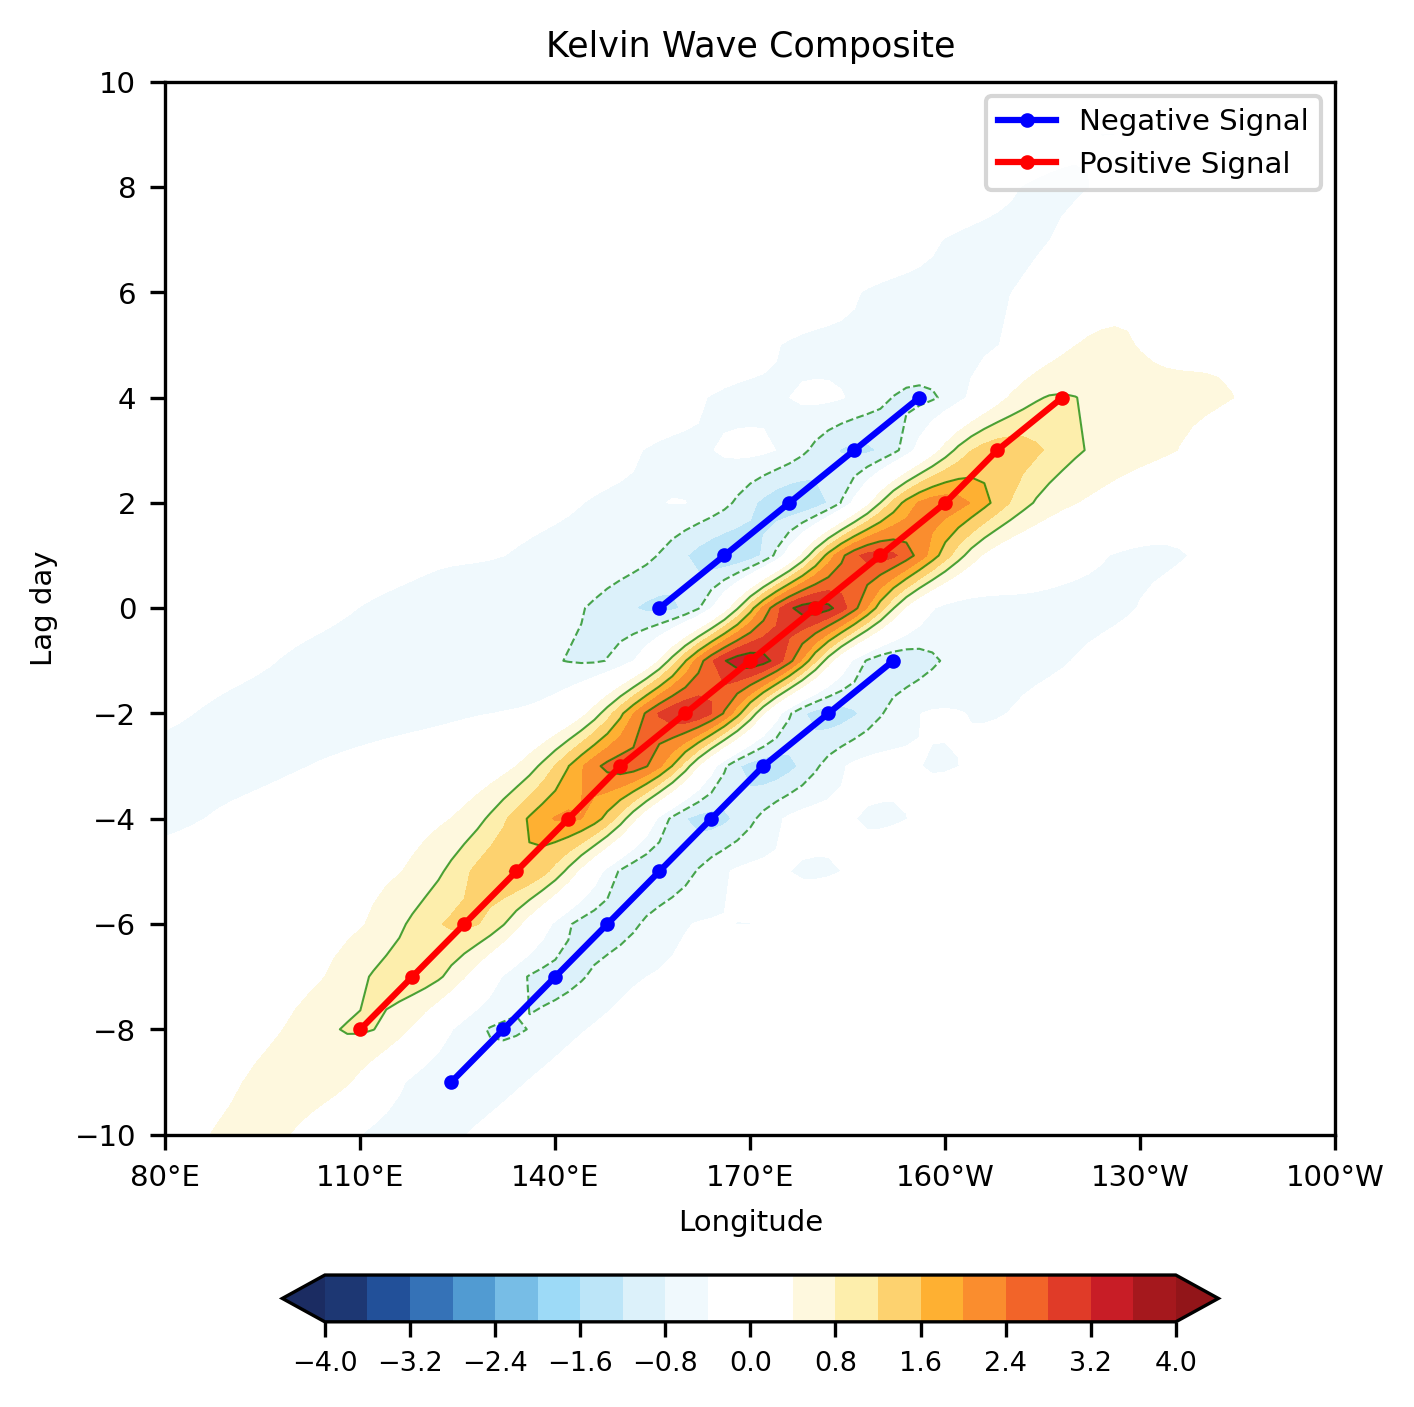

In [7]:
# -*- coding: utf-8 -*-
"""
Created on %(date)s

@author: jianpu

@email : xianpuji@hhu.edu.cn

# ================================================================================================
# Author: %(Jianpu)s | Affiliation: Hohai
# Email : %(email)s
# Last modified:  'date': time.strftime("%Y-%m-%d %H:%M"),
# Filename: 
# =================================================================================================

"""


def read_netcdf_data(file_path, variables):
    """读取NetCDF文件数据"""
    with Dataset(file_path, "r") as data:
        return {var: data.variables[var][:] for var in variables}
    




def get_track_signal(data,lon_2d,time_2d):
    
    data_smooth = gaussian_filter(data, sigma=.1)
    # Step 2: 设定阈值（防止噪声影响）
    threshold = np.max(np.abs(data_smooth)) * .2  # 仅考虑高于 30% 最大值的信号

    # Step 3: 计算每行（时间步）的最大值和最小值索引
    pos_indices = np.argmax(data_smooth, axis=1)
    neg_indices = np.argmin(data_smooth, axis=1)

    # 获取对应的值
    pos_values = data_smooth[np.arange(data.shape[0]), pos_indices]
    neg_values = data_smooth[np.arange(data.shape[0]), neg_indices]
    # 允许的最大跳跃（经度变化）
    max_jump = 20

    valid_pos = np.abs(pos_values) > threshold
    valid_neg = np.abs(neg_values) > threshold

    # 存储正负信号的分段轨迹
    filtered_pos_segments = []
    filtered_neg_segments = []

    # 追踪当前的正负信号轨迹
    current_pos_segment = []
    current_neg_segment = []

    for i in range(data.shape[0]):
        pos_lon = lon_2d[i, pos_indices[i]]
        pos_time = time_2d[i, pos_indices[i]]
        neg_lon = lon_2d[i, neg_indices[i]]
        neg_time = time_2d[i, neg_indices[i]]
        # 处理正信号
        if valid_pos[i]:
            if len(current_pos_segment) > 0:
                prev_pos_lon, prev_pos_time = current_pos_segment[-1]
                
                # 规则1: 避免正信号跳跃
                if abs(pos_lon - prev_pos_lon) > max_jump:
                    filtered_pos_segments.append(current_pos_segment)
                    current_pos_segment = []
        
                # 规则2: 确保正信号不会跨越负信号（检查是否为空）
                if len(current_neg_segment) > 0 and len(filtered_neg_segments) > 0:
                    last_neg_time = current_neg_segment[-1][1]
                    last_filtered_neg_time = filtered_neg_segments[-1][-1][1]
                    if last_neg_time < pos_time < last_filtered_neg_time:
                        filtered_pos_segments.append(current_pos_segment)
                        current_pos_segment = []
        
            current_pos_segment.append((pos_lon, pos_time))
        
        # 处理负信号
        if valid_neg[i]:
            if len(current_neg_segment) > 0:
                prev_neg_lon, prev_neg_time = current_neg_segment[-1]
        
                # 规则1: 避免负信号跳跃
                if abs(neg_lon - prev_neg_lon) > max_jump:
                    filtered_neg_segments.append(current_neg_segment)
                    current_neg_segment = []
        
                # 规则2: 确保负信号不会跨越正信号（检查是否为空）
                if len(current_pos_segment) > 0 and len(filtered_pos_segments) > 0:
                    last_pos_time = current_pos_segment[-1][1]
                    last_filtered_pos_time = filtered_pos_segments[-1][-1][1]
                    if last_pos_time < neg_time < last_filtered_pos_time:
                        filtered_neg_segments.append(current_neg_segment)
                        current_neg_segment = []
        
            current_neg_segment.append((neg_lon, neg_time))


    # 记录最后的轨迹段
    if current_pos_segment:
        filtered_pos_segments.append(current_pos_segment)
    if current_neg_segment:
        filtered_neg_segments.append(current_neg_segment)
        
    return filtered_neg_segments,filtered_pos_segments

def plot_hovmoller_with_max_min(data_dict, plot_params, save_path):
    """
    绘制 Hovmöller 图，并在同一张图上连线最大值轨迹和最小值轨迹。

    参数
    ----------
    data_dict : dict
        包含以下键值对:
        - 'pr_kw_hovmoller': 2D数组, shape = (21, 180)
        - 'lont': 2D数组, shape = (21, 180), 对应每个网格点的经度
        - 'tlon': 2D数组, shape = (21, 180), 对应每个网格点的时间/滞后天数

    plot_params : dict
        - "clev": 等值填色的 levels
        - "cticks": colorbar 的刻度
        - "contour_levels": {'positive': [...], 'negative': [...]}
        - "title": 图标题
        - "xlim", "ylim": x, y 轴的范围

    save_path : str
        保存图片的文件路径
    """
    # 从 plot_params 中解包所需参数
    clev = plot_params['clev']
    cticks = plot_params['cticks']
    contour_levels = plot_params['contour_levels']
    title = plot_params['title']
    xlim = plot_params['xlim']
    ylim = plot_params['ylim']

    # 如果没有自定义cmap，这里示例使用 matplotlib 自带的 RdBu_r
    cmap = cmaps.BlueWhiteOrangeRed

    # 取出数据
    pr_data = data_dict['pr_kw_hovmoller']  # shape: (21, 180)
    lon_2d  = data_dict['lont']            # shape: (21, 180)
    time_2d = data_dict['tlon']            # shape: (21, 180)

    # 检查数据形状
    print("数据形状检查:")
    print(f"pr_kw_hovmoller: {pr_data.shape}")
    print(f"lont: {lon_2d.shape}")
    print(f"tlon: {time_2d.shape}")

    # 创建画布
    fig, ax = plt.subplots(figsize=(5, 6), dpi=300)
    plt.rcParams.update({'font.size': 7})
    plt.subplots_adjust(left=0.15, right=0.93, top=0.9, bottom=0.12)

    # 使用 contourf 绘制填色图
    cf = ax.contourf(
        lon_2d, 
        time_2d, 
        pr_data, 
        levels=clev, 
        cmap=cmap, 
        extend='both'
    )

    # 绘制等值线（正值、负值分开，以区分实线/虚线）
    cs_p = ax.contour(
        lon_2d, 
        time_2d, 
        pr_data,
        levels=contour_levels['positive'],
        colors='g', 
        linewidths=0.5,alpha=0.7
    )
    cs_n = ax.contour(
        lon_2d, 
        time_2d, 
        pr_data,
        levels=contour_levels['negative'],
        colors='g', 
        linestyles='dashed', 
        linewidths=0.5,alpha=0.7
    )

    # =============================
    # 在此处进行“最大值”和“最小值”轨迹连线
    # =============================
    neg_segments,pos_segments  = get_track_signal(pr_data, lon_2d, time_2d)
    
    first_negative = True
    first_positive = True
    for segment in neg_segments:
        segment_lon, segment_time = zip(*segment)  # 拆分经度和时间
        if first_negative:
            ax.plot(segment_lon, segment_time, 'b-', marker='o', markersize=2.5, label="Negative Signal")
            first_negative = False  # 之后的负信号不再设置 label
        else:
            ax.plot(segment_lon, segment_time, 'b-', marker='o', markersize=2.5)
        
    for segment in pos_segments:
        segment_lon, segment_time = zip(*segment)
        if first_positive:
            ax.plot(segment_lon, segment_time, 'r-', marker='o', markersize=2.5, label="Positive Signal")
            first_negative = False  # 之后的负信号不再设置 label
        else:
            ax.plot(segment_lon, segment_time, 'r-', marker='o', markersize=2.5)
      
    
    # 轴设置
    ax.set(
        xlabel='Longitude',
        ylabel='Lag day',
        title=title,
        xlim=xlim,
        ylim=ylim
    )

    # 如果需要自定义 x 轴或 y 轴的刻度格式，可在此添加
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.xaxis.set_major_locator(ticker.MultipleLocator(30))
    ax.set_xticks(np.arange(80, 270, 30))
    ax.set_yticks(np.arange(-10, 12, 2))
    
    # 颜色条
    cb = fig.colorbar(cf, ax=ax, orientation='horizontal', shrink=0.8, pad=0.1)
    cb.set_ticks(cticks)
    cb.ax.tick_params(labelsize=6.5)

 
    ax.legend(loc='best', fontsize=7)

    # 保存并显示
    plt.savefig(save_path, format='png', dpi=300)
    plt.show()
    plt.close()

# 配置参数（可根据自己需要修改）
config = {
    "file_path": r"I:/kw_composite_lag_lon_prano_prkw.nc",
    "variables": ['pr_kw_comp', 'lont', 'tlon'],  # 这里自行修改成实际所需变量
    "plot_params": {
        "clev": np.arange(-4, 4.4, 0.4),
        "cticks": np.arange(-4, 4.8, 0.8),
        "contour_levels": {
            "positive": np.arange(0.8, 4.8, 0.8),
            "negative": np.arange(-4, 0, 0.8)
        },
        "title": "Kelvin Wave Composite",
        "xlim": [80, 260],
        "ylim": [-10, 10]
    },
    "save_path": "fig_lon_t_hovmoller_prano_vs_kwpr.png",
}

# 读取数据
raw_data = read_netcdf_data(config["file_path"], config["variables"])
# 准备绘图数据
# 注意：这里假设 pr_kw_comp, lont, tlon 的形状都是 (21, 180)
plot_data = {
    'pr_kw_hovmoller': raw_data['pr_kw_comp'],
    'lont': raw_data['lont'],
    'tlon': raw_data['tlon']
}

# 绘制带最大/最小值连线的 Hovmöller 图
plot_hovmoller_with_max_min(plot_data, config["plot_params"], config["save_path"])




